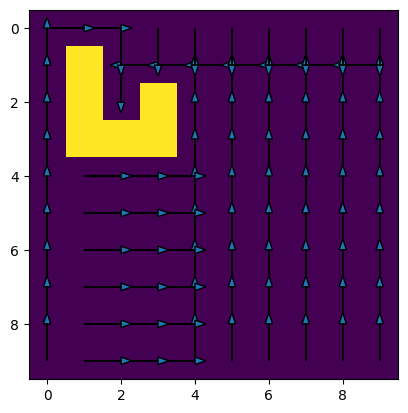

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

H = np.zeros([100,100])

# H[10:80,10:20] = 1
# H[40:48,30:75] = 1
# H[0:40, 50:52] = 1
# H[75: 85, 50: 100] = 1

H = np.zeros([10,10])
H[1: 4,1] = 1
H[3,1:4] = 1
H[2:4,3] = 1
# plt.imshow(H, interpolation='none')
# plt.show()
def generate_flow_field(grid, start):
    frontier = []
    frontier.append(start)
    came_from = dict()
    came_from[start] = None
    directions = [(0,1),(1,0),(0,-1),(-1,0)]
    while len(frontier) > 0:
        current = frontier.pop(0)
        for direction in directions:
            nextval = (direction[0] + current[0], direction[1] + current[1])
            if nextval[0] >= 0 and nextval[0] < len(grid) and nextval[1] >= 0 and nextval[1] < len(grid[0]) and nextval not in came_from and grid[current] == 0 and grid[nextval] == 0:   
                frontier.append(nextval)
                came_from[nextval] = current
    
    return came_from
came_from = generate_flow_field(H,(2,2))
for key in came_from:
    point = came_from[key]
    if point:
        plt.arrow(key[1],key[0],point[1]-key[1],point[0]-key[0],head_width = 0.2)
plt.imshow(H, interpolation='none')
plt.show()

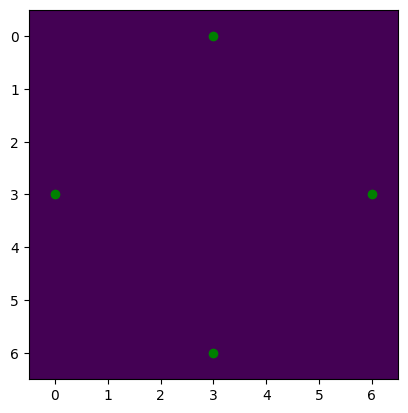

In [4]:
grid = np.zeros([7,7])

agents = set()
agents.add((3,0))
agents.add((0,3))

goals = set()
agents.add((3,6,0))
agents.add((6,3,1))
plt.imshow(grid, interpolation='none')
for agent in agents:
    plt.plot(agent[0],agent[1], '-go')

for goal in goals:
    plt.plot(goal[0],goal[1], '-go')
plt.show()

In [52]:
from queue import PriorityQueue
from dataclasses import dataclass, field
from typing import Any

# Prio queue compare prio only
@dataclass(order=True) 
class PrioritizedItem:
    priority: int
    item: Any=field(compare=False)

# 3D hash table ReservationTable to keep track of Agent state
class ReservationTable:
    def __init__(self):
        self.table = {}

    def reserve(self, x, y, time, agent_id):
        self.table[(x, y, time)] = agent_id
    
    def is_reserved(self, x, y, time):
        return (x, y, time) in self.table
    
    def get_reserver(self, x, y, time):
        if (x, y, time) in self.table:
            return self.table[(x,y,time)]
        else:
            return -1

# The agent start & goal positions in 2d space
class Agent:
    def __init__(self, id, start, goal):
        self.id = id
        self.start = start
        self.goal = goal

class Position:
    def __init__(self, x ,y):
        self.x = x
        self.y = y
    
    # Equality operator (==) overide comparison between position objects 
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

# Available actions 
# Movement 
class Action:
    MOVE_UP = (0, 1)
    MOVE_RIGHT = (1, 0)
    MOVE_LEFT = (-1, 0)
    MOVE_DOWN = (0, -1)
    WAIT = (0, 0)

    @classmethod
    def get_actions(cls):
        return [cls.MOVE_UP, cls.MOVE_DOWN, cls.MOVE_LEFT, cls.MOVE_RIGHT, cls.WAIT]


# Node object to keep track of visited cells to be reconstructed later
class Node:
    def __init__(self, priority, position, time, cost, parent=None):
        priority = priority
        self.x = position.x
        self.y = position.y
        self.time = time
        self.cost = cost
        self.parent = parent #Node pointer to parent node

    def calculate_f_cost(self):
        self.f_cost = self.g_cost + self.h_cost


def reconstruct_path(node):
    path = []
    current = node
    while current:
        path.append((Position(current.x, current.y), current.time))
        current = current.parent
    return list(reversed(path))

# Manhattan distance heuristic
def manhattan_distance(pos1, pos2):
    return abs(pos1.x - pos2.x) + abs(pos1.y - pos2.y)

# TODO: Implimented this heuristic function
# Source - https://github.com/balzer82/3D-OccupancyGrid-Python/blob/master/3D-AStar-PathPlanning.ipynb
# Heuristic berechnen
# def calcheuristic(grid,goal):

#     for z in range(zdim):
#         for y in range(ydim):
#             for x in range(xdim):
                 
#                 # Euklidische Distanz für jede Zelle zum Ziel berechnen
#                 dist=((x-goal[0])**2+(y-goal[1])**2+(z-goal[2])**2)**(1/2.0)
            
#                 # Höhe
#                 zheu = -6.0*float(z)
                
#                 # Horizontale von Soll
#                 yheu = np.abs(float(y) - goal[1])
                
#                 # und Höhe und Abweichung von y=0
#                 heuristic[x,y,z]= dist + yheu #+ zheu
#     '''     
#     for i in range(len(heuristic)):
#         print(heuristic[i])
#     '''
#     return heuristic

In [86]:
# TODO: Impliment robot state standstill to fill future reservation slots
# Source- https://www.davidsilver.uk/wp-content/uploads/2020/03/coop-path-AIIDE.pdf
# Cooperative A* - A decoupled approach with each agent's path calculated one at a time
# Each path's route passed into a 3D hash table containing a route's position 
# & at what time <X,Y,time>. Entries in the table are considered impassable by subsequent
# agent searches.
# Encountered issues:
# - When robot reaches goal, subquent time intervals lack the information of this end state (fixed)
# - Even when the end state information is saved, the implimentaion still leads to cases where subsequent agents pass
#   through previously finished agents when visualized. This happens in cases where an earlier agent path whose calculated
#   path is longer than a later agent's. This translates to the later agent arriving at the goal first and reserving that spot
#   only AFTER the previous agent has already calculated it's path; the later agent had no information of the previous end state.
#   This is fixed by using the hierarchical CA*
# - With end state persistentence, there are certain agent-goal configurations where later agents are blocked off from their goal
#       - Leads to a "lost" agent
# - If two adjacent agents attempt to travel to eachother's cell at the same time interval, this allows them to "phase through eachother"
                                     
def cooperative_astar(agent_list, grid, max_time = 100):
    #print("In CA* \n")
    reservationTable = ReservationTable()
    paths = {}
    

    # class Agent:
    #   def __init__(self, id, start, goal):
    #     self.id = id
    #     self.start = start
    #     self.goal = goal
    for agent in agent_list:
        #print("Agent ID [" + str(agent.id) + "]\n")
        start = agent.start
        goal = agent.goal
        openlist = PriorityQueue(maxsize = 0)
        closedlist = set()

        # --Node members--
        # priority = priority
        # self.x = position.x
        # self.y = position.y
        # self.time = time
        # self.cost = cost
        # self.parent = parent

        # Initial node
        start_node = Node(
            priority = 0,
            position = start,
            time = 0,
            cost = 0
        )
        # Wrap the start node in PrioritizedItem
        openlist.put(PrioritizedItem(priority=0, item=start_node))

        path_found = False
        # Node initializer
        node_count = 0
        while not openlist.empty():
            #Current type - Node item
            current_item = openlist.get()
            current = current_item.item

            node_count += 1

            #print("t= " + str(current.time) + " | Current Node #: " + str(node_count) + " at [" + str(current.x) + " , " + str(current.y) 
                 # + "] - Cost: " + str(current.cost))
            
            if (current.time >= max_time): #Check
                path_found = False
                break

            # Reconstruct path and store after path calculation
            if Position(current.x, current.y) == goal:
                paths[agent] = reconstruct_path(current)
                
                # Reserve the entire path including the goal state
                for pos, time in paths[agent]:
                    reservationTable.reserve(pos.x, pos.y, time, agent.id)
                
                goal_pos = paths[agent][-1]  # Last position in path
                goal_time = goal_pos[1]      # Time when goal is reached
                
                # Reserve the goal position for all future timesteps
                for future_time in range(goal_time, max_time):
                    reservationTable.reserve(goal_pos[0].x, goal_pos[0].y, future_time, agent.id)
                
                #print(f"Agent {agent.id} reached goal at ({goal_pos[0].x},{goal_pos[0].y}) at time {goal_time}")
                path_found = True
                break
            
            # Skip if already visited
            current_pos = (current.x, current.y, current.time)
            if current_pos in closedlist:
                continue
            # And add to closed list if not
            closedlist.add(current_pos)

            # Consider all movement options including wait()
            for action in Action.get_actions():
                next_x = current.x + action[0]
                next_y = current.y + action[1]
                next_time = current.time + 1

                # reserve_check = reservationTable.is_reserved(next_x, next_y, next_time)
                #if (reserve_check):
                    #print("Encountered reserved cell at: <%s, %s, time=%s>" % (str(next_x), str(next_y), str(next_time)))

                
                if (0 <= next_x < len(grid) and 
                    0 <= next_y < len(grid[0]) and 
                    grid[next_x][next_y] == 0 and # Check if within valid bounds
                    not reservationTable.is_reserved(next_x, next_y, next_time)
                    ):

                    # g-cost (cost from start)
                    new_cost = current.cost + 1

                    # h-cost (heuristic estimate to goal)
                    heuristic = manhattan_distance(
                        Position(next_x, next_y),
                        agent.goal
                    )
                    # f-cost (total estimated cost: f = g + h)
                    priority = new_cost + heuristic

                    next_node = Node(
                        priority = priority,
                        position = Position(next_x, next_y),
                        time = next_time,
                        cost = new_cost,
                        parent = current #
                    )

                    openlist.put(PrioritizedItem(priority = priority, item = next_node))

        # If path is unable to be found, set agent path to none       
        if not path_found:
            print(f"No path found for agent {agent.id}")
            paths[agent] = None
            
    return paths


def hierarchical_cooperative_astar(agent_list, grid):
    def sortfunc(agent):
        return manhattan_distance(agent.start,agent.goal)
    return cooperative_astar(sorted(agent_list,key=sortfunc),grid)


In [87]:
# Variation of CA* to discourage two agents "phasing" through eachother 
def swapless_cooperative_astar(agent_list, grid, max_time = 100):
    print("In Swapless CA* \n")
    reservationTable = ReservationTable()
    paths = {}
    

    # class Agent:
    #   def __init__(self, id, start, goal):
    #     self.id = id
    #     self.start = start
    #     self.goal = goal
    for agent in agent_list:
        # print("Agent ID [" + str(agent.id) + "]\n")
        start = agent.start
        goal = agent.goal
        openlist = PriorityQueue(maxsize = 0)
        closedlist = set()

        # Initial node
        start_node = Node(
            priority = 0,
            position = start,
            time = 0,
            cost = 0
        )
        # Wrap the start node in PrioritizedItem
        openlist.put(PrioritizedItem(priority=0, item=start_node))

        path_found = False

        # Node initializer
        node_count = 0
        while not openlist.empty():
            #Current type - Node item
            current_item = openlist.get()
            current = current_item.item

            node_count += 1

            # print("t= " + str(current.time) + " | Current Node #: " + str(node_count) + " at [" + str(current.x) + " , " + str(current.y) 
                #   + "] - Cost: " + str(current.cost))

            #print(current)

            if (current.time >= max_time): #Check
                path_found = False
                break

            # Reconstruct path and store after path calculation
            if Position(current.x, current.y) == goal:
                paths[agent] = reconstruct_path(current)
                
                # Reserve the entire path including the goal state
                for pos, time in paths[agent]:
                    reservationTable.reserve(pos.x, pos.y, time, agent.id)
                
                goal_pos = paths[agent][-1]  # Last position in path
                goal_time = goal_pos[1]      # Time when goal is reached
                
                # Reserve the goal position for all future timesteps
                for future_time in range(goal_time, max_time):
                    reservationTable.reserve(goal_pos[0].x, goal_pos[0].y, future_time, agent.id)
                
                #print(f"Agent {agent.id} reached goal at ({goal_pos[0].x},{goal_pos[0].y}) at time {goal_time}")
                path_found = True
                break
            
            # Skip if already visited
            current_pos = (current.x, current.y, current.time)
            if current_pos in closedlist:
                continue
            # And add to closed list if not
            closedlist.add(current_pos)

            # Consider all movement options including wait()
            for action in Action.get_actions():
                next_x = current.x + action[0]
                next_y = current.y + action[1]
                next_time = current.time + 1

                def check_swap(reservationTable,current,next_x,next_y,next_time):
                    a = reservationTable.get_reserver(next_x,next_y,current.time)
                    b = reservationTable.get_reserver(current.x, current.y, next_time)
                    if a == -1 and b == -1:
                        return False
                    elif a == b:
                        return True
                    else:
                        return False
                # reserve_check = reservationTable.is_reserved(next_x, next_y, next_time)
                # if (reserve_check):
                    # print("Encountered reserved cell at: <%s, %s, time=%s>" % (str(next_x), str(next_y), str(next_time)))

                if (0 <= next_x < len(grid) and 
                    0 <= next_y < len(grid[0]) and 
                    grid[next_x][next_y] == 0 and # Check if within valid bounds
                    not reservationTable.is_reserved(next_x, next_y, next_time) and
                    not check_swap(reservationTable,current,next_x,next_y,next_time)
                    ):

                    # g-cost (cost from start)
                    new_cost = current.cost + 1

                    # h-cost (heuristic estimate to goal)
                    heuristic = manhattan_distance(
                        Position(next_x, next_y),
                        agent.goal
                    )
                    # f-cost (total estimated cost: f = g + h)
                    priority = new_cost + heuristic
                

                    next_node = Node(
                        priority = priority,
                        position = Position(next_x, next_y),
                        time = next_time,
                        cost = new_cost,
                        parent = current #
                    )

                    openlist.put(PrioritizedItem(priority = priority, item = next_node))

        # If path is unable to be found, set agent path to none       
        if not path_found:
            print(f"No path found for agent {agent.id}")
            paths[agent] = None
            
    return paths

def hierarchical_swl_cooperative_astar(agent_list, grid):
    def sortfunc(agent):
        return manhattan_distance(agent.start,agent.goal)
    return swapless_cooperative_astar(sorted(agent_list,key=sortfunc),grid)

In [62]:

agents = [
    Agent(1, Position(3, 0), Position(3, 6)),
    Agent(2, Position(0, 3), Position(6, 3))
]

# Find paths
paths = cooperative_astar(agents, grid)


# Print results
for agent, path in paths.items():
    print(f"Agent {agent.id} path:")
    for pos, time in path:
        print(f"t={time}: ({pos.x}, {pos.y})")

Last position: Agent 1 @ 3,6
Last position: Agent 2 @ 6,3
Agent 1 path:
t=0: (3, 0)
t=1: (3, 1)
t=2: (3, 2)
t=3: (4, 2)
t=4: (4, 3)
t=5: (4, 4)
t=6: (3, 4)
t=7: (3, 5)
t=8: (3, 6)
Agent 2 path:
t=0: (0, 3)
t=1: (1, 3)
t=2: (2, 3)
t=3: (2, 2)
t=4: (3, 2)
t=5: (4, 2)
t=6: (4, 3)
t=7: (5, 3)
t=8: (6, 3)


In [42]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from datetime import datetime

# Visualize the calculated routes
# Runs another window and saves .gif to output folder
def visualize(grid, paths):
    # Create figure with extra space for text
    fig = plt.figure(figsize=(8, 9))
    
    # Create a gridspec to manage subplot layout
    gs = plt.GridSpec(2, 1, height_ratios=[1, 8])
    
    # Create separate axes for text and grid
    text_ax = fig.add_subplot(gs[0])
    grid_ax = fig.add_subplot(gs[1])
    
    # Define a set of colors for agents - Move this up before plotting paths
    colors = plt.cm.get_cmap("tab10", len(paths))
    
    # Plot planned paths
    for idx, (agent, path) in enumerate(paths.items()):
        path_x = [pos.y for pos, _ in path]
        path_y = [pos.x for pos, _ in path]
        
    
        color = colors(idx)
        grid_ax.plot(path_x, path_y, color=color, alpha=0.5, linewidth=1)
        
        # Add arrows to show direction
        for i in range(len(path_x)-1):
            dx = path_x[i+1] - path_x[i]
            dy = path_y[i+1] - path_y[i]
            grid_ax.arrow(path_x[i], path_y[i], dx*0.3, dy*0.3,
                        head_width=0.1, head_length=0.1, 
                        color=color, alpha=0.5)
    
    text_ax.axis('off')
    time_text = text_ax.text(0.5, 0.5, '', ha='center', va='center', fontsize=14, transform=text_ax.transAxes)

    grid_ax.set_xticks(range(grid.shape[1]))
    grid_ax.set_yticks(range(grid.shape[0]))
    grid_ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    grid_ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    grid_ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    grid_ax.set_xticklabels([])
    grid_ax.set_yticklabels([])
    grid_ax.set_xlim(-0.5, grid.shape[1] - 0.5)
    grid_ax.set_ylim(-0.5, grid.shape[0] - 0.5)

    # Visualize obstacles
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == 1:  # Obstacle
                rect = plt.Rectangle((y - 0.5, x - 0.5), 1, 1, color="black")
                grid_ax.add_patch(rect)
    # Define a set of colors for agents
    colors = plt.cm.get_cmap("tab10", len(paths))

    # Mark initial positions and goals
    for idx, (agent, path) in enumerate(paths.items()):
        start = path[0][0]  # Unpack Position object for start
        goal = path[-1][0]  # Unpack Position object for goal
        color = colors(idx)
        grid_ax.text(start.y, start.x, 'A', color=color, ha='center', va='center', fontsize=14)
        grid_ax.text(goal.y, goal.x, 'G', color=color, ha='center', va='center', fontsize=14)

    # Create the animation
    frames = max(len(path) for path in paths.values())
    patches = []

    for idx, path in enumerate(paths.values()):
        pos, _ = path[0]  # Unpack first Position object and time
        color = colors(idx)
        patch = plt.Circle((pos.y, pos.x), 0.3, color=color, animated=True)
        grid_ax.add_patch(patch)
        patches.append((patch, path))

    # Add time display text
    # time_text = grid_ax.text(0.02, 0.98, '', transform=grid_ax.transAxes, fontsize=12)

    def update(frame):
        # Update agent positions
        for patch, path in patches:
            if frame < len(path):
                pos, time = path[frame]  # Now we use both position and time
                patch.center = (pos.y, pos.x)
        
        # Update time display
        time_text.set_text(f'Time Step: {frame}')
        
        return [patch for patch, _ in patches] + [time_text]
    ani = animation.FuncAnimation(fig, update, frames=frames, blit=True, interval=500, repeat=False)

    writer = animation.PillowWriter(fps=2,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800)
    
    save = str(datetime.now().strftime("outputs/1-1-%d-%m-%Y_%H-%M-%S.gif"))
    ani.save(save, writer=writer)
    # plt.show()

In [71]:
agents = [
    Agent(1, Position(3, 0), Position(3, 6)),
    Agent(2, Position(0, 3), Position(6, 3))
]
grid = np.zeros([7,7])
grid[3][3] = 1


complex_grid = np.zeros([8,8])
complex_agents = [
        Agent(1, Position(3, 0), Position(3, 7)),
        Agent(2, Position(0, 0), Position(7, 7)),
        Agent(3, Position(7, 0), Position(0, 7)),
        Agent(4, Position(2, 2), Position(5, 5)),
        Agent(5, Position(5, 3), Position(1, 6))
    ]


# Find paths
# Identify prohibited positions (start and goal positions of agents)
prohibited_positions = set()
for agent in complex_agents:
    prohibited_positions.add((agent.start.x, agent.start.y))
    prohibited_positions.add((agent.goal.x, agent.goal.y))

# Add 1s to the complex grid without placing on prohibited positions
positions_added = 0  # Counter for added positions
for _ in range(10):
    x = np.random.randint(0, 8)
    y = np.random.randint(0, 8)
    if (x, y) not in prohibited_positions and complex_grid[x, y] == 0:
        complex_grid[x, y] = 1
        positions_added += 1
paths = cooperative_astar(agents, grid)


complex_paths = hierarchical_cooperative_astar(complex_agents, complex_grid)


swap_agents = [
    Agent(1, Position(3, 0), Position(3, 6)),
    Agent(2, Position(3, 6), Position(3, 0))
]
swap_grid = np.zeros([7,7])


swap_paths = cooperative_astar(swap_agents, swap_grid)
swapless_paths = swapless_cooperative_astar(swap_agents,swap_grid)
# Print results
for agent, path in paths.items():
    print(f"Agent {agent.id} path:")
    for pos, time in path:
        print(f"t={time}: ({pos.x}, {pos.y})")

Last position: Agent 1 @ 3,6
Last position: Agent 2 @ 6,3
Last position: Agent 4 @ 5,5
Last position: Agent 1 @ 3,7
Last position: Agent 5 @ 1,6
Last position: Agent 2 @ 7,7
Last position: Agent 3 @ 0,7
Last position: Agent 1 @ 3,6
Last position: Agent 2 @ 3,0
In Swapless CA* 

Last position: Agent 1 @ (<__main__.Position object at 0x1098d8190>, 6)
Last position: Agent 2 @ (<__main__.Position object at 0x10fd632d0>, 8)
Agent 1 path:
t=0: (3, 0)
t=1: (3, 1)
t=2: (3, 2)
t=3: (4, 2)
t=4: (4, 3)
t=5: (4, 4)
t=6: (3, 4)
t=7: (3, 5)
t=8: (3, 6)
Agent 2 path:
t=0: (0, 3)
t=1: (1, 3)
t=2: (2, 3)
t=3: (2, 2)
t=4: (3, 2)
t=5: (4, 2)
t=6: (4, 3)
t=7: (5, 3)
t=8: (6, 3)


In [37]:
# visualize(complex_grid, complex_paths)

# if paths:
#     visualize(grid, paths)


# visualize(complex_grid, complex_paths)

# visualize(swap_grid, swap_paths)
# visualize(swap_grid, swapless_paths)

In [83]:
import time

@dataclass
class PerformanceMetrics:
    total_agents: int
    total_runs: int
    successful_runs: int
    failed_agents: list
    path_lengths: list
    path_times: list
    run_times: list

    def get_run_success_rate(self):
        return (self.successful_runs / self.total_runs) * 100
    
    def get_agent_success_rate(self):
        return (1 - (len(self.failed_agents)/ self.total_agents) ) * 100
    
    def get_average_path_length(self):
        return np.mean(self.path_lengths)
    
    def get_average_completion_time(self):
        return np.mean(self.path_times)
    
    def get_average_computation_time(self):
        return np.mean(self.run_times)
    


def get_unique(grid_size, prohibited_positions):
    while True: 
        pos = (np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1]))
        if pos not in prohibited_positions:
            return pos
        


# grid_size type tuple [x, y]
def get_performance(num_runs, grid_size, num_agents, num_obstacles, function_type = 0, save_gif = True):
    metrics = PerformanceMetrics(
        total_runs = 0,
        total_agents = num_agents * num_runs,
        successful_runs = 0,
        failed_agents = [], # failed agents should be a list of [run#, agent id] pairs
        path_lengths = [],
        path_times = [],
        run_times = [],
    )

    for run in range(num_runs):

        # initialize iteration start state
        prohibited_positions = set()
        grid = np.zeros(grid_size)
        agents = []

        # add agent start and goal
        for agentid in range(1, num_agents + 1):
            start = get_unique(grid_size, prohibited_positions)
            prohibited_positions.add(start)
            goal = get_unique(grid_size, prohibited_positions)
            prohibited_positions.add(goal)
            agents.append(Agent(agentid, Position(start[0], start[1]), Position(goal[0], goal[1])))
        
        # add obstacle locations
        for _ in range(num_obstacles):
            obs = get_unique(grid_size, prohibited_positions)
            prohibited_positions.add(obs)
            grid[obs[0], obs[1]] = 1
        
        # calculate paths
        start_time = time.time()
        match function_type:
            case 0:
                paths = cooperative_astar(agents, grid)
            case 1:
                paths = hierarchical_cooperative_astar(agents, grid)
            case 2:
                paths = swapless_cooperative_astar(agents, grid)
            case 3:
                paths = hierarchical_swl_cooperative_astar(agents, grid)
        total_computation_time = time.time() - start_time

        run_success = True

        # paths = {Agent Object: [(Postion, Time), ..]}
        for agent, path in paths.items():
            if path == None:
                run_success = False
                metrics.failed_agents.append([run, agent.id])
                continue
            _, final_time = path[-1]  # Get the last position-time pair
            metrics.path_lengths.append(len(path))
            metrics.path_times.append(final_time)

        
        metrics.total_runs += 1
        if run_success:
            metrics.successful_runs += 1
        metrics.run_times.append(total_computation_time)
        if all(path is not None for path in paths.values()) and save_gif:
            visualize(grid, paths)
            
    return metrics

def print_results(metric: PerformanceMetrics):
    print(f"Performance Results:")
    print(f"Total Runs: {metric.total_runs:}")
    print(f"Run Success Rate: {metric.get_run_success_rate():.2f}%")
    print(f"Total Agents: {metric.total_agents:}")
    print(f"Failed Agents: {len(metric.failed_agents)}")
    print(f"Agent Success Rate: {metric.get_agent_success_rate():.2f}%")
    print(f"Average Path Length: {metric.get_average_path_length():.2f}")
    print(f"Average Computation Time: {metric.get_average_computation_time():.3f} seconds")



Agent 1 reached goal at (3,2) at time 2
Agent 2 reached goal at (1,5) at time 8
Agent 3 reached goal at (4,6) at time 9
Agent 4 reached goal at (3,6) at time 5
Agent 5 reached goal at (3,1) at time 15


/var/folders/nw/149c6db91b12cbp4ml340v940000gn/T/ipykernel_10072/2743611820.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(paths))
/var/folders/nw/149c6db91b12cbp4ml340v940000gn/T/ipykernel_10072/2743611820.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(paths))


Performance Results:
Total Runs: 1.000000
Run Success Rate: 100.00%
Total Agents: 5.000000
Failed Agents: 0
Agent Success Rate: 100.00%
Average Path Length: 8.80
Average Computation Time: 0.005 seconds


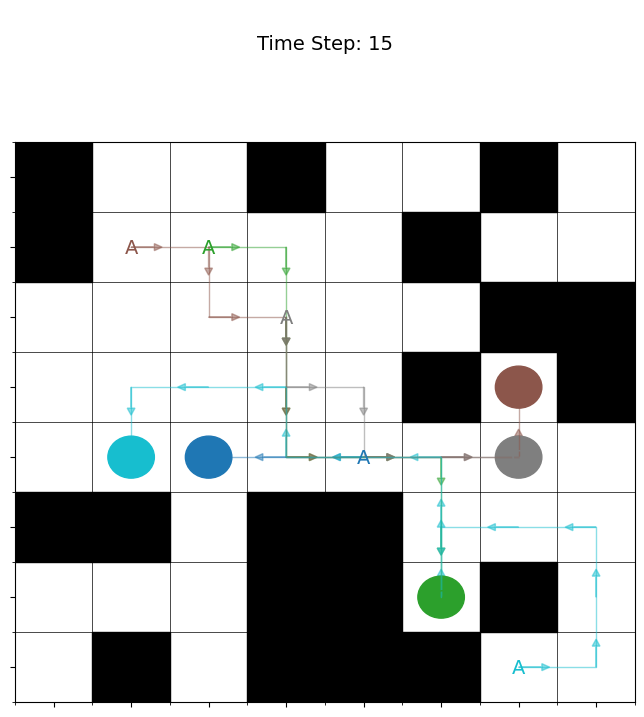

In [82]:
metrics = get_performance(num_runs=1, grid_size=(8,8), num_agents=5, num_obstacles=20)
print_results(metrics)

---Older Code---

C:\Users\Rylan\AppData\Local\Temp\ipykernel_19480\3410801396.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(paths))


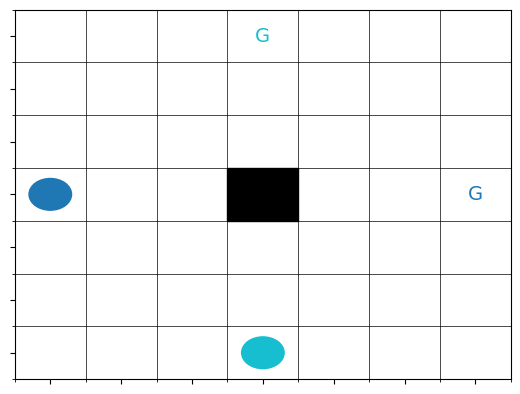

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def visualize(grid, paths):
    # Initialize figure and axis
    fig, ax = plt.subplots()
    ax.set_xticks(range(grid.shape[1]))
    ax.set_yticks(range(grid.shape[0]))
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(-0.5, grid.shape[1] - 0.5)
    ax.set_ylim(-0.5, grid.shape[0] - 0.5)

    # Visualize obstacles
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == 1:  # Obstacle
                rect = plt.Rectangle((y - 0.5, x - 0.5), 1, 1, color="black")
                ax.add_patch(rect)
    # Define a set of colors for agents
    colors = plt.cm.get_cmap("tab10", len(paths))

    # Mark initial positions and goals
    for idx, (agent, path) in enumerate(paths.items()):
        start = path[0][0]  # Unpack Position object for start
        goal = path[-1][0]  # Unpack Position object for goal
        color = colors(idx)
        ax.text(start.y, start.x, 'A', color=color, ha='center', va='center', fontsize=14)
        ax.text(goal.y, goal.x, 'G', color=color, ha='center', va='center', fontsize=14)

    # Create the animation
    frames = max(len(path) for path in paths.values())
    patches = []

    for idx, path in enumerate(paths.values()):
        pos, _ = path[0]  # Unpack first Position object and time
        color = colors(idx)
        patch = plt.Circle((pos.y, pos.x), 0.3, color=color, animated=True)
        ax.add_patch(patch)
        patches.append((patch, path))

    def update(frame):
        for patch, path in patches:
            if frame < len(path):
                pos, _ = path[frame]  # Unpack Position object and time
                patch.center = (pos.y, pos.x)
        return [patch for patch, _ in patches]

    ani = animation.FuncAnimation(fig, update, frames=frames, blit=True, interval=500, repeat=False)
    plt.show()
# Visualize the paths
if paths:
    visualize(grid, paths)

In [26]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# import numpy as np

# def create_grid(grid_size, reservations, paths):
#     """
#     Create an initial grid visualization showing reservations and agent paths.
#     """
#     grid = np.zeros(grid_size)

#     for (x, y, t), agent_id in reservations.items():
#         grid[x, y] = -1  # Reserved cells

#     return grid

# def update_grid(grid, reservations, paths, current_time):
#     """
#     Update the grid visualization with the current positions of agents.
#     """
#     grid[:] = 0  # Reset grid

#     # Update with reservations
#     for (x, y, t), agent_id in reservations.items():
#         if t == current_time:
#             grid[x, y] = -1

#     # Update with agent positions from paths
#     for agent_id, path in paths.items():
#         for pos, t in path:
#             if t == current_time:
#                 grid[pos.x, pos.y] = agent_id + 1

#     return grid

# def visualize_paths(grid, reservations, paths, time_steps):
#     """
#     Visualize the grid updates over time.
#     """
#     fig, ax = plt.subplots()
#     cmap = plt.cm.get_cmap("viridis", len(paths) + 2)  # Custom colormap
#     ax.set_xticks(range(len(grid)))
#     ax.set_yticks(range(len(grid[0])))
#     ax.set_xticks(np.arange(-0.5, len(grid[0]), 1), minor=True)
#     ax.set_yticks(np.arange(-0.5, len(grid), 1), minor=True)
#     ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

#     # Initialize grid
#     def update(frame):
#         current_grid = update_grid(grid.copy(), reservations, paths, frame)
#         ax.clear()
#         ax.imshow(current_grid, cmap=cmap, vmin=-1, vmax=len(paths) + 1)
#         ax.set_title(f"Time step: {frame}")
#         ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
#         ax.set_xticks(np.arange(-0.5, len(grid[0]), 1), minor=True)
#         ax.set_yticks(np.arange(-0.5, len(grid), 1), minor=True)
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])

#     ani = FuncAnimation(fig, update, frames=range(time_steps), interval=500, repeat=False)
#     plt.show()

# # Example usage (simple test):
# if __name__ == "__main__":
#     # Grid: 0 = free, 1 = obstacle
#     grid = np.zeros([7,7])

#     # Simulate paths and reservations (as output from cooperative_astar)
#     test_reservations = {(0, 0, 0): 0, (1, 0, 1): 0}
# # Find paths
#     paths = cooperative_astar(agents, grid)

#     # Visualize
#     visualize_paths(grid, test_reservations, paths,)


In CA* 

Agent ID [1]

t= 0 | Current Node #: 1 at [3 , 0] - Cost: 0
t= 1 | Current Node #: 2 at [3 , 1] - Cost: 1
t= 2 | Current Node #: 3 at [3 , 2] - Cost: 2
t= 3 | Current Node #: 4 at [3 , 3] - Cost: 3
t= 4 | Current Node #: 5 at [3 , 4] - Cost: 4
t= 5 | Current Node #: 6 at [3 , 5] - Cost: 5
t= 6 | Current Node #: 7 at [3 , 6] - Cost: 6
Agent ID [2]

t= 0 | Current Node #: 1 at [0 , 3] - Cost: 0
t= 1 | Current Node #: 2 at [1 , 3] - Cost: 1
t= 2 | Current Node #: 3 at [2 , 3] - Cost: 2
Encountered reserved cell at: <3, 3, time=3>
t= 1 | Current Node #: 4 at [0 , 3] - Cost: 1
t= 2 | Current Node #: 5 at [1 , 3] - Cost: 2
t= 2 | Current Node #: 6 at [1 , 3] - Cost: 2
t= 3 | Current Node #: 7 at [2 , 3] - Cost: 3
t= 3 | Current Node #: 8 at [2 , 3] - Cost: 3
t= 4 | Current Node #: 9 at [3 , 3] - Cost: 4
t= 5 | Current Node #: 10 at [4 , 3] - Cost: 5
t= 6 | Current Node #: 11 at [5 , 3] - Cost: 6
t= 7 | Current Node #: 12 at [6 , 3] - Cost: 7


TypeError: visualize_paths() missing 1 required positional argument: 'time_steps'